In [1]:
pip install ib_insync

In [34]:
from ib_insync import *

ib = IB()

await ib.connectAsync('127.0.0.1', 7497, clientId=1)
print("Connected to Interactive Brokers API")


Connected to Interactive Brokers API


In [35]:
from ib_insync import *
import pytz
import pandas as pd

contract = Future('ES', '202406', 'CME')
await ib.qualifyContractsAsync(contract)

historical_data = await ib.reqHistoricalDataAsync(
    contract, endDateTime='', durationStr='30 D',
    barSizeSetting='1 hour', whatToShow='MIDPOINT', useRTH=True
)

tz = pytz.timezone('US/Eastern')
for bar in historical_data:
    bar.date = bar.date.astimezone(tz)

df = pd.DataFrame([vars(bar) for bar in historical_data])

print(df)

                         date     open     high      low    close  volume  \
0   2024-03-21 09:30:00-04:00  5315.00  5321.50  5308.50  5315.50    -1.0   
1   2024-03-21 10:00:00-04:00  5315.50  5321.50  5312.75  5317.50    -1.0   
2   2024-03-21 11:00:00-04:00  5317.50  5320.75  5311.50  5319.00    -1.0   
3   2024-03-21 12:00:00-04:00  5319.00  5322.75  5315.75  5319.00    -1.0   
4   2024-03-21 13:00:00-04:00  5319.00  5319.25  5308.50  5309.50    -1.0   
..                        ...      ...      ...      ...      ...     ...   
232 2024-05-02 09:30:00-04:00  5083.25  5088.75  5057.75  5061.25    -1.0   
233 2024-05-02 10:00:00-04:00  5061.25  5068.00  5036.25  5066.00    -1.0   
234 2024-05-02 11:00:00-04:00  5066.00  5072.75  5054.75  5069.25    -1.0   
235 2024-05-02 12:00:00-04:00  5069.25  5070.25  5054.50  5064.25    -1.0   
236 2024-05-02 13:00:00-04:00  5064.25  5079.00  5064.00  5077.50    -1.0   

     average  barCount  
0       -1.0        -1  
1       -1.0        -1  


In [15]:
!pip install nest_asyncio

In [171]:
#Model construction and training
import nest_asyncio
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
nest_asyncio.apply()
class LSTMModel():
    # Model initialization
    def __init__(self, sequence_size=60, lstm_units=50, dense_units=25, drop_out_rates=0.2):
        self.sequence_size = sequence_size
        self.lstm_units = lstm_units
        self.dense_units = dense_units
        self.drop_out_rates = drop_out_rates
        self.model = None
    # Preprocess data for model training
    def preprocess_data(self,filepath):
        data = pd.read_csv(filepath)
        features = data[['close', 'high', 'low', 'volume']].values # Fetch 4 columns from dataframe
        scaler = MinMaxScaler(feature_range=(0, 1))# Initialize scaler and normalize data to a range of 0 to 1.
        scaled_features = scaler.fit_transform(features)# Scaling each feature to the range (0,1) depending on the values 
        return scaled_features, scaler

    # Create sequences for LSTM training
    def create_sequences(self,data):
        inputSequence = [] #initialize input sequence
        targetSequence = [] #initialize target sequence
        sequenceFormationLength = len(data) - self.sequence_size;
        for i in range(sequenceFormationLength): # iteration of data to form sequence    
            inputSequence.append(data[i:(i + self.sequence_size)]) # Appending a piece of data from i to i + sequence_size
            targetSequence.append(data[i + self.sequence_size, 0])# Used for prediction of the future close price
        return np.array(inputSequence), np.array(targetSequence)
    # Construct LSTM model 
    def build_lstm_model(self,input_shape):
        lstmLayerWithSequence = LSTM(self.lstm_units, return_sequences=True, input_shape=input_shape)
        self.model = Sequential([
            lstmLayerWithSequence, # LSTM layer with 50 neurons and returning full sequence which passed into the next layer as an input
            Dropout(self.drop_out_rates), # Dropout layer added to prevent overfitting
            LSTM(self.lstm_units), # Only the last output of the output sequence is returned and reduce dimensionality
            Dropout(self.drop_out_rates), # Dropout layer added to prevent overfitting
            Dense(self.dense_units), # Fully-connected layer with 25 neurons that process the features fetched by the recurrent layers through interpretation and process of the output of prediction.
            Dense(1) # Fully-connected layer with 1 neuron that outputs the predicted value
        ])
        self.model.compile(optimizer='adam', loss='mean_squared_error') # Compile with Adam optimizer and configured the model for training
    # Plotting model learning
    def plot_model_learning(self, history):
        plt.figure(figsize=(11, 6))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()
    # Inverse transform futures' prices
    def inverse_transform_price(self, scaler, prices, feature_array): 
        feature_array[:, 0] = prices # Assign the price in the column where close price is stored
        return scaler.inverse_transform(feature_array)[:, 0]# Column for close price transformed
    # Plot predictions
    def plot_predictions(self, actual, predicted):
        plt.figure(figsize=(11, 6))
        plt.plot(actual, label='Actual Price', color='blue')
        plt.plot(predicted, label='Predicted Price', color='red')
        plt.title('Actual vs Predicted Prices')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()
    # Preprocess security data
    def preprocess_security_data(self, data, filename):
        data.to_csv(filename, index=False)
    # Model makes prediction
    def predict(self, data):
        return self.model.predict(data)
    # Train model
    def train(self, inputs, targets, validation_data, epochs=10, batch_size=32):
        return self.model.fit(inputs, targets, epochs=epochs, batch_size=batch_size, validation_data=validation_data)
    

In [172]:
# Prediction
def predict_security_price(model, scaler, data, current_price):
    scaled_data = data.reshape(1, -1, 4)  # Reshape scaled data passed into LSTM model as an input
    scaled_prediction = model.predict(scaled_data)  # Model makes prediction based on scaled data
    features = np.zeros((1, 4))# Use 4 features as per scaler fitting, one row and four columns, which correspond to the 4 features
    features[0, 0] = scaled_prediction[0][0]# Predicted price goes into the position of close price
    predicted_price = scaler.inverse_transform(features)[0, 0]# Inverse transform and fetch the close price, the scaled prediction is converted back to the original scale of the data
    return predicted_price, current_price

#Making trade decision based on predicted price and current price
def trade_decision(predicted_price, current_price, available_funds, current_shares):
    transaction_fee = 2.25
    available_funds = float(available_funds)
    decision = "HOLD"
    shares = 0
    price_elastic_buffer = current_price * (0.5 / 100)# Readjust the price price difference between predicted price and actual price by a ratio of 0.5% of actual price 
    if predicted_price + price_elastic_buffer > current_price and available_funds > transaction_fee and available_funds / current_price >= 50:
        if (available_funds - transaction_fee)/ current_price >= 50:
            decision = "BUY"
            shares = 1
    elif predicted_price + price_elastic_buffer < current_price and current_shares > 0:
        decision = "SELL"
        shares = 1
        
    return decision, shares, predicted_price

[0.61623325 0.65405831 0.4105595  0.79511426 0.52009456 0.90149724
 0.32230102 0.20252167 0.03861308 0.39243499 0.76910954 0.28684003
 0.72419228 0.29472025 0.9535067  0.10874704 0.20252167 0.28526399
 0.84712372 0.14814815 0.61702128 0.5248227  0.66824271 0.16312057
 0.14026793 0.44759653 0.32308905 0.48463357 0.18676123 0.67218282
 0.83609141 0.29078014 0.44208038 0.8179669  0.93380615 0.81481481]


2024-05-02 18:41:36.732659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-02 18:41:36.735249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-02 18:41:36.736568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-05-02 18:41:37.208091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-02 18:41:37.209446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-02 18:41:37.210703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/6 [========================>.....] - ETA: 0s - loss: 0.1368

2024-05-02 18:41:40.181154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-02 18:41:40.182386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-02 18:41:40.183608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 4s 154ms/step - loss: 0.1260 - val_loss: 0.0238
Epoch 2/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0336 - val_loss: 0.0140
Epoch 3/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0215 - val_loss: 0.0244
Epoch 4/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0208 - val_loss: 0.0127
Epoch 5/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0198 - val_loss: 0.0122
Epoch 6/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0154 - val_loss: 0.0149
Epoch 7/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0164 - val_loss: 0.0133
Epoch 8/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0133 - val_loss: 0.0122
Epoch 9/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0138 - val_loss: 0.0126
Epoch 10/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0129 - val_loss: 0.0122
Epoch 11/50
6/6 [======================

2024-05-02 18:41:49.895140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-02 18:41:49.896628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-02 18:41:49.897795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 7ms/step


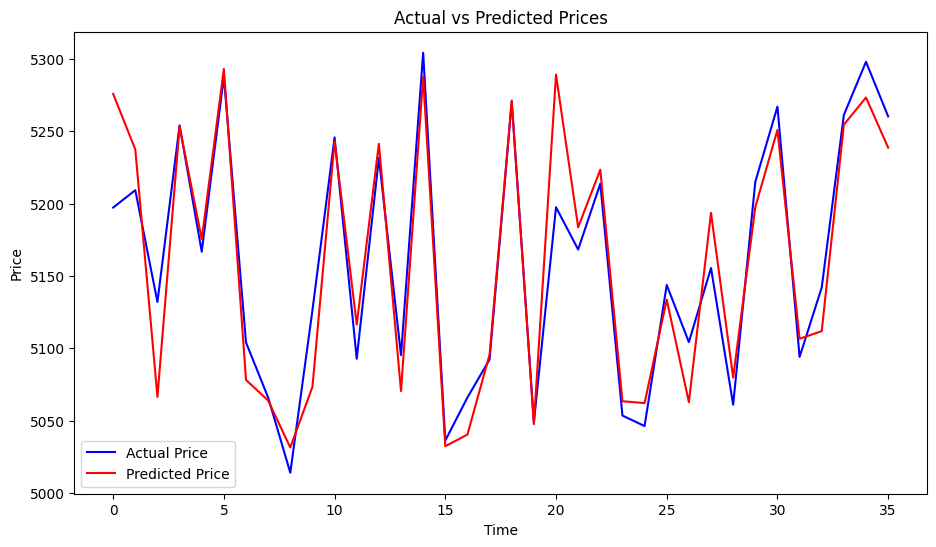

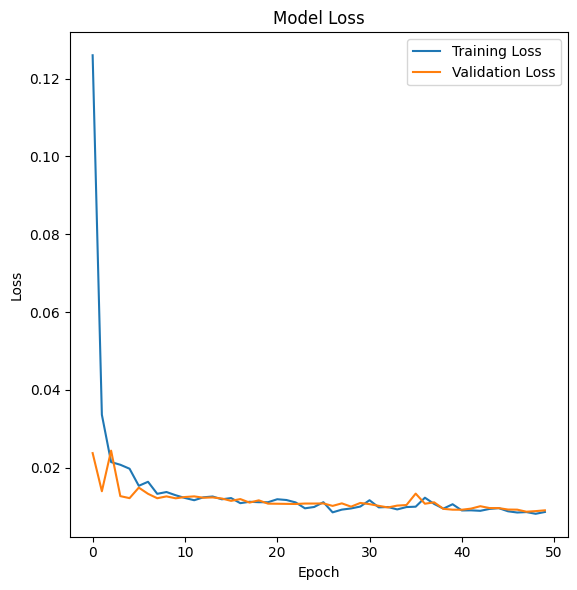

In [178]:
# Fetching current price
async def fetchCurrentPrice():
    #Fetching price for every trading hour
    historical_data = await ib.reqHistoricalDataAsync(
        contract, endDateTime='', durationStr='30 D',
        barSizeSetting='1 hour', whatToShow='MIDPOINT', useRTH=True
    )

    tz = pytz.timezone('US/Eastern')
    for bar in historical_data:
        bar.date = bar.date.astimezone(tz)

    df = pd.DataFrame([vars(bar) for bar in historical_data])
    price = historical_data[len(historical_data)-1].close
    return price


# Model building and plotting model performance indicators
def build_model():
    model = LSTMModel(sequence_size=60, lstm_units=50, dense_units=25)
    model.preprocess_security_data(df, 'ib_es500_price_history.csv')
    features = ['close', 'high', 'low', 'volume']
    scaled_features, scaler = model.preprocess_data(filepath)
    inputs, targets = model.create_sequences(scaled_features)
    x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)
    print(y_test)
    input_shape = x_train.shape[1], x_train.shape[2]
    model.build_lstm_model(input_shape)
    history = model.train(inputs, targets, (x_test, y_test), epochs=50, batch_size=32)
    predicted_scaled = model.predict(x_test)
    array_predicted = np.zeros((len(predicted_scaled.flatten()), 4))
    array_actual = np.zeros((len(y_test), 4))
    predicted_prices = model.inverse_transform_price(scaler, predicted_scaled.flatten(), array_predicted)
    actual_prices = model.inverse_transform_price(scaler, y_test, array_actual)
    model.plot_predictions(actual_prices, predicted_prices)
    model.plot_model_learning(history)
build_model()

In [177]:
# Price prediction and execution of trade decision
def fetchMostRecentData():
    model.preprocess_and_save_data(df, 'ib_es500_price_history.csv')
    filepath = 'ib_es500_price_history.csv'
    scaled_features, scaler = model.preprocess_data(filepath)
    return scaled_features
# Execute price prediction
async def execute_prediction():
    positions = ib.positions()
    current_shares = 0
    for pos in positions:
        if pos.contract.symbol == 'ES' and pos.contract.secType == 'FUT':
            current_shares = pos.position     
    account_summary = await ib.accountSummaryAsync()
    balance = next((item for item in account_summary if item.tag == 'TotalCashBalance'), None)
    available_funds = balance.value
    contract = Future('ES', '202406', 'CME')
    util.sleep(5)
    current_price = await fetchCurrentPrice()
    total_cost = current_shares * current_price  # Simulated total cost of current shares
    recent_data = fetchMostRecentData()[-60:]  # most recent 60 prices used for prediction
    predicted_price, current_price = predict_security_price(model, scaler, recent_data, current_price)
    decision, shares, predicted_price = trade_decision(predicted_price, current_price, available_funds, current_shares)
    
    return decision, shares, predicted_price, current_price
# Execute trade decision
def execute_trade_decision(decision, shares, predicted_price, current_price):
    print(f"Current price: {current_price}. Predicted price: {predicted_price}")
    if decision == "BUY":
        order = MarketOrder('BUY', shares)
        ib.placeOrder(contract, order)
        print(f"Trade decision: {decision}")
        print(f"Request to {decision} {shares} shares has been completed.")
    elif decision == "SELL":
        print(f"Trade decision: {decision}")
        order = MarketOrder('SELL', shares)
        ib.placeOrder(contract, order)
        print(f"Request to {decision} {shares} shares has been completed.")
    elif decision == "HOLD":
        print(f"Trade decision: {decision}")
        print("Request to HOLD, no trade action.")
decision, shares, predicted_price, current_price = await execute_prediction()
execute_trade_decision(decision, shares, predicted_price, current_price)

1/1 [==============================] - 0s 21ms/step
Current price: 5090.0. Predicted price: 5066.721347048879
Trade decision: BUY
Request to BUY 1 shares has been completed.


Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1102, reqId -1: Connectivity between IBKR and Trader Workstation has been restored - data maintained. All data farms are connected: usfuture; usfarm; ushmds; secdefnj.
